In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import torch
import sys
import anndata
from torch.utils.data import DataLoader
import os
# import scib

In [3]:
%autoreload 2
from self_supervision.data.datamodules import MultiomicsDataloader
from self_supervision.trainer.multiomics.multiomics_utils import one_hot_encode
from self_supervision.tester.multiomics.test import get_pred_dir, pearson_corr_per_cell

In [4]:
# Define font and tick properties
font = {'family': 'sans-serif', 'size': 5}  # Adjust the size as needed
fontdict = {'family': 'sans-serif', 'fontsize': 5}  # Adjust the size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # For tick labels

# Set the colorblind friendly palette
# Setting the style for the plots
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

# Get the list of colors in the palette
palette_colors = sns.color_palette("colorblind")

# Access the colors
color_supervised = palette_colors[0]  # First color
color_ssl = palette_colors[1]  # Second color
color_zeroshot = palette_colors[2]  # Third color
color_baseline = palette_colors[3]  # Forth color, ([3] looks similar to [0])
color_else1 = palette_colors[5]
color_else2 = palette_colors[6]
color_else3 = palette_colors[7]

In [5]:
RESULT_PATH = '/lustre/groups/ml01/workspace/till.richter/ssl_results'

# Evaluate Models

In [6]:
ADATA_PATH = "/lustre/groups/ml01/workspace/till.richter/"
MODEL_PATH = "/lustre/groups/ml01/workspace/till.richter/trained_models/"

In [7]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, "NeurIPS_filtered_hvg_adata.h5ad"))
adata

AnnData object with n_obs × n_vars = 90261 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [8]:
test_ds = MultiomicsDataloader(np.log1p(adata[adata.obs['split'] == 'test'].obsm['protein_counts']),
                            adata[adata.obs['split'] == 'test'].X.todense(),
                            one_hot_encode(adata[adata.obs['split'] == 'test'].obs['batch']))

ood_test_ds = MultiomicsDataloader(np.log1p(adata[adata.obs['split'] == 'ood_test'].obsm['protein_counts']),
                                adata[adata.obs['split'] == 'ood_test'].X.todense(),
                                one_hot_encode(adata[adata.obs['split'] == 'ood_test'].obs['batch']))

In [9]:
test_dl = DataLoader(test_ds, shuffle=False, batch_size=512, num_workers=0)  
ood_test_dl = DataLoader(ood_test_ds, shuffle=False, batch_size=512, num_workers=0)  

In [10]:
len(test_dl.dataset.proteins)

8154

## a) All Models Comparison

In [11]:
model_dirs = [
    # SUPERVISED
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt",  # median of 5 runs
    
    # Negative Binomial Fit
    # MODEL_PATH + "/final_models/multiomics/NegBin_No_SSL_run0/default/version_1/checkpoints/best_checkpoint_val.ckpt",

    # SELF-SUPERVISED ON NEURIPS DATA
    # BYOL
    # MODEL_PATH + "/final_models/multiomics/SSL_BYOL_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # Barlow Twins
    # MODEL_PATH + "/final_models/multiomics/SSL_BT_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # GP to GP
    # MODEL_PATH + "/final_models/multiomics/SSL_GP_to_GP_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # GP to TF
    # MODEL_PATH + "/final_models/multiomics/SSL_GP_to_TF_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # Random Mask
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # GP Mask
    # TO DO
    
    # SELF-SUPERVISED ON 20M DATA
    # BYOL
    # MODEL_PATH + "/final_models/multiomics/SSL_BYOL_20Mrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # Barlow Twins
    # MODEL_PATH + "/final_models/multiomics/SSL_BT_20Mrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # GP to GP 
    # MODEL_PATH + "/final_models/multiomics/SSL_GP_to_GP_20Mrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # GP to TF
    # MODEL_PATH + "/final_models/multiomics/SSL_GP_to_TF_20Mrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    # Random Mask
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",  # median of 5 runs
    
    # GP Mask
    # MODEL_PATH + "/final_models/multiomics/SSL_Gene_Program_Mask_20Mrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
]

In [12]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata, test_dl=test_dl)

Getting predictions for New_No_SSL_run2...
Getting predictions for SSL_Random_Mask_NeurIPSrun0...
Getting predictions for SSL_Random_Mask_20Mrun5...


In [13]:
results_df, mean_results_df = pearson_corr_per_cell(observed=test_ds.proteins, predictions=all_protein_predictions)

### Cross-Modality Prediction

In [14]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata, test_dl=test_dl)

Getting predictions for New_No_SSL_run2...
Getting predictions for SSL_Random_Mask_NeurIPSrun0...
Getting predictions for SSL_Random_Mask_20Mrun5...


In [15]:
results_df, mean_results_df = pearson_corr_per_cell(observed=test_ds.proteins, predictions=all_protein_predictions)

In [16]:
mean_results_df

,Model,Pearson Correlation,MSE
0,New_No_SSL_run2,0.860644,0.434684
1,SSL_Random_Mask_20Mrun5,0.871533,0.376298
2,SSL_Random_Mask_NeurIPSrun0,0.864074,0.447130


In [17]:
# TotalVI results from baseline notebook
# Run0
# Pearson Correlation Coefficient: 0.8557939158392955
# Mean Squared Error: 14548.7333984375
# Run1
# Pearson Correlation Coefficient: 0.8586541502884995
# Mean Squared Error: 14967.298828125
# Run2
# Pearson Correlation Coefficient: 0.8629891237001892
# Mean Squared Error: 15031.1923828125
# Run3
# Pearson Correlation Coefficient: 0.8629891237001892
# Mean Squared Error: 15031.1923828125
# Run4
# Pearson Correlation Coefficient: 0.8627571110671045  # median run
# Mean Squared Error: 14263.40234375  # Ignore MSE, different calculation

# Adding the new row
new_row = {'Model': 'totalVI', 'Pearson Correlation': 0.8627571110671045, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
mean_results_df = mean_results_df.drop_duplicates()
mean_results_df = mean_results_df[~mean_results_df['Model'].isin(['NegBin_No_SSL_run0'])]

model_names = {
    'New_No_SSL_run2': 'Supervised',
    'SSL_BT_20Mrun0': 'Self-Supervised\nscTab\nBarlowTwins',
    'SSL_BT_NeurIPSrun0': 'Self-Supervised\nNeurIPS\nBarlowTwins',
    'SSL_BYOL_20Mrun0': 'Self-Supervised\nscTab\nBYOL',
    'SSL_BYOL_NeurIPSrun0': 'Self-Supervised\nNeurIPS\nBYOL',
    'SSL_GP_to_GP_20Mrun0': 'Self-Supervised\nscTab\nGP to GP',
    'SSL_GP_to_GP_NeurIPSrun0': 'Self-Supervised\nNeurIPS\nGP to GP',
    'SSL_GP_to_TF_20Mrun0': 'Self-Supervised\nscTab\nGP to TF',
    'SSL_GP_to_TF_NeurIPSrun0': 'Self-Supervised\nNeurIPS\nGP to TF',
    'SSL_Gene_Program_Mask_20Mrun0': 'Self-Supervised\nscTab\nGene Program Mask',
    'SSL_Random_Mask_20Mrun5': 'Self-Supervised\nscTab\nRandom Mask',
    'SSL_Random_Mask_NeurIPSrun0': 'Self-Supervised\nNeurIPS\nRandom Mask',
    'totalVI': 'totalVI'
}

mean_results_df['Model'] = mean_results_df['Model'].map(model_names)


mean_results_df

,Model,Pearson Correlation,MSE
0,Supervised,0.860644,0.434684
1,Self-Supervised\nscTab\nRandom Mask,0.871533,0.376298
2,Self-Supervised\nNeurIPS\nRandom Mask,0.864074,0.44713
3,totalVI,0.862757,None


/tmp/ipykernel_2280503/2053102632.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), **tick_font)


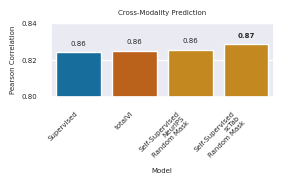

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt



model_colors = [color_supervised, palette_colors[3], color_ssl, color_ssl]

def annotate_bars(ax):
    for i, p in enumerate(ax.patches):
        vertical_offset = p.get_height() * 0.01
        font_weight = 'bold' if i == len(ax.patches) - 1 else 'normal'
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height() + vertical_offset),
                    ha='center', va='baseline',
                    **font, weight=font_weight)

# Plot for Pearson Correlation
plt.figure(figsize=(3, 2))
ax = sns.barplot(x='Model', y='Pearson Correlation', data=mean_results_df.sort_values('Pearson Correlation'), palette=model_colors)
ax.set_ylim(0.8, 0.9)  # Adjust this range based on your data

# Set the font for the tick labels and rotate them for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', **tick_font)
plt.setp(ax.get_xticklabels(), va="top", ha="right")

ax.set_yticklabels(ax.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Pearson Correlation', fontdict=font)
ax.set_title('Cross-Modality Prediction', fontdict=font)

# Annotate bars
annotate_bars(ax)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/multiomics/Model_Comparison_Cross_Modality.svg", bbox_inches='tight')  # Save as SVG
plt.show()



## b) Supervised vs. Self-Supervised with stochastic runs

In [22]:
model_dirs = [
    # MODEL_PATH + "/final_models/multiomics/New_No_SSL_run0/default/version_5/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/New_No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/No_SSL_new_run8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/No_SSL_new_run9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
        
    
    # SELF-SUPERVISED ON 20M DATA
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    
    # SELF-SUPERVISED ON NEURIPS DATA
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun3/default/version_1/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
]

### Cross-Modality Prediction

In [23]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata, test_dl=test_dl)

Getting predictions for New_No_SSL_run1...
Getting predictions for New_No_SSL_run2...
Getting predictions for New_No_SSL_run3...
Getting predictions for No_SSL_new_run8...
Getting predictions for No_SSL_new_run9...
Getting predictions for SSL_Random_Mask_20Mrun5...
Getting predictions for SSL_Random_Mask_20Mrun6...
Getting predictions for SSL_Random_Mask_20Mrun7...
Getting predictions for SSL_Random_Mask_20Mrun8...
Getting predictions for SSL_Random_Mask_20Mrun9...
Getting predictions for SSL_Random_Mask_NeurIPSrun0...
Getting predictions for SSL_Random_Mask_NeurIPSrun1...
Getting predictions for SSL_Random_Mask_NeurIPSrun2...
Getting predictions for SSL_Random_Mask_NeurIPSrun4...
Getting predictions for SSL_Random_Mask_NeurIPSrun9...


In [24]:
results_df, mean_results_df = pearson_corr_per_cell(observed=test_ds.proteins, predictions=all_protein_predictions)

In [25]:
mean_results_df

,Model,Pearson Correlation,MSE
0,New_No_SSL_run1,0.859662,0.424459
1,New_No_SSL_run2,0.860644,0.434684
2,New_No_SSL_run3,0.862003,0.436064
3,No_SSL_new_run8,0.866688,0.425999
4,No_SSL_new_run9,0.864961,0.422648
5,SSL_Random_Mask_20Mrun5,0.871533,0.376298
6,SSL_Random_Mask_20Mrun6,0.868857,0.388953
7,SSL_Random_Mask_20Mrun7,0.872039,0.385076
8,SSL_Random_Mask_20Mrun8,0.872318,0.383617
9,SSL_Random_Mask_20Mrun9,0.871679,0.391081


In [26]:
# TotalVI results from baseline notebook
# Run0
# Pearson Correlation Coefficient: 0.8557939158392955
# Mean Squared Error: 14548.7333984375
# Run1
# Pearson Correlation Coefficient: 0.8586541502884995
# Mean Squared Error: 14967.298828125
# Run2
# Pearson Correlation Coefficient: 0.8629891237001892
# Mean Squared Error: 15031.1923828125
# Run3
# Pearson Correlation Coefficient: 0.8629891237001892
# Mean Squared Error: 15031.1923828125
# Run4
# Pearson Correlation Coefficient: 0.8627571110671045  # median run
# Mean Squared Error: 14263.40234375  # Ignore MSE, different calculation

new_row = {'Model': 'totalVI_run0', 'Pearson Correlation': 0.8557939158392955, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
new_row = {'Model': 'totalVI_run1', 'Pearson Correlation': 0.8586541502884995, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
new_row = {'Model': 'totalVI_run2', 'Pearson Correlation': 0.8629891237001892, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
new_row = {'Model': 'totalVI_run3', 'Pearson Correlation': 0.8629891237001892, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
new_row = {'Model': 'totalVI_run4', 'Pearson Correlation': 0.8627571110671045, 'MSE': None}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)
# From Baseline Notebook
new_row = {'Model': 'Linear', 'Pearson Correlation': 0.8085559483994267, 'MSE': 1.1918474435806274}
mean_results_df = mean_results_df.append(new_row, ignore_index=True)

mean_results_df

,Model,Pearson Correlation,MSE
0,New_No_SSL_run1,0.859662,0.424459
1,New_No_SSL_run2,0.860644,0.434684
2,New_No_SSL_run3,0.862003,0.436064
3,No_SSL_new_run8,0.866688,0.425999
4,No_SSL_new_run9,0.864961,0.422648
5,SSL_Random_Mask_20Mrun5,0.871533,0.376298
6,SSL_Random_Mask_20Mrun6,0.868857,0.388953
7,SSL_Random_Mask_20Mrun7,0.872039,0.385076
8,SSL_Random_Mask_20Mrun8,0.872318,0.383617
9,SSL_Random_Mask_20Mrun9,0.871679,0.391081


In [16]:
np.std((0.864074, 0.863630, 0.866362, 0.863227, 0.869592))

0.002371023745136277

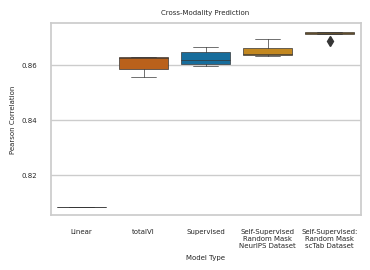

In [29]:
# Rename models
def rename_model(model_name):
    if "No_SSL" in model_name:
        return "Supervised"
    elif "SSL_Random_Mask" in model_name and "20M" in model_name:
        return "Self-Supervised:\nRandom Mask\nscTab Dataset"
    elif "SSL_Random_Mask" in model_name and "NeurIPS" in model_name:
        return "Self-Supervised\nRandom Mask\nNeurIPS Dataset"
    elif "totalVI" in model_name:
        return "totalVI"
    elif "Linear" in model_name:
        return "Linear"
    else:
        return model_name

mean_results_df['Model Type'] = mean_results_df['Model'].apply(rename_model)

# Define the order of models
model_order = ["Linear", "totalVI", "Supervised", "Self-Supervised\nRandom Mask\nNeurIPS Dataset", "Self-Supervised:\nRandom Mask\nscTab Dataset"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised:\nRandom Mask\nscTab Dataset": color_ssl,
    "Self-Supervised\nRandom Mask\nNeurIPS Dataset": color_ssl,
    "totalVI": palette_colors[3],
    "Linear": palette_colors[3],
}

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels

# Box plot for Pearson Correlation
plt.figure(figsize=(4, 2.5))
ax1 = sns.boxplot(x='Model Type', y='Pearson Correlation', data=mean_results_df, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xlabel('Model Type', fontdict=font)
ax1.set_ylabel('Pearson Correlation', fontdict=font)
ax1.set_title('Cross-Modality Prediction', fontdict=font)

# Set font for all tick labels to match the fontdict
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/multiomics/pearson_corr.svg", bbox_inches='tight')  # Save as SVG

# Box plot for MSE
# plt.figure(figsize=(3, 2))
# ax2 = sns.boxplot(x='Model Type', y='MSE', data=mean_results_df.sort_values('MSE', ascending=False), linewidth=0.5)
# ax2.set_xlabel('Model Type', fontdict=font)
# ax2.set_ylabel('MSE', fontdict=font)
# ax2.set_title('Cross-Modality Prediction', fontdict=font)

# Set font for all tick labels to match the fontdict
# tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)
# plt.savefig(RESULT_PATH + "/multiomics/mse.svg", bbox_inches='tight')  # Save as SVG

plt.show()

### Holdout set

In [15]:
model_dirs = [
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run0/default/version_5/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/New_No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/No_SSL_new_run8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/No_SSL_new_run9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
        
    
    # SELF-SUPERVISED ON 20M DATA
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
    
    # SELF-SUPERVISED ON NEURIPS DATA
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun1/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun2/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun3/default/version_1/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun4/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun5/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun6/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun7/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    # MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_NeurIPSrun9/default/version_0/checkpoints/best_checkpoint_val.ckpt",
    
]

In [16]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata, test_dl=ood_test_dl)

Getting predictions for New_No_SSL_run0...
Getting predictions for New_No_SSL_run1...
Getting predictions for New_No_SSL_run2...
Getting predictions for New_No_SSL_run3...
Getting predictions for No_SSL_new_run9...
Getting predictions for SSL_Random_Mask_20Mrun5...
Getting predictions for SSL_Random_Mask_20Mrun6...
Getting predictions for SSL_Random_Mask_20Mrun7...
Getting predictions for SSL_Random_Mask_20Mrun8...
Getting predictions for SSL_Random_Mask_20Mrun9...
Getting predictions for SSL_Random_Mask_NeurIPSrun0...
Getting predictions for SSL_Random_Mask_NeurIPSrun1...
Getting predictions for SSL_Random_Mask_NeurIPSrun3...
Getting predictions for SSL_Random_Mask_NeurIPSrun4...
Getting predictions for SSL_Random_Mask_NeurIPSrun9...


In [17]:
results_df, mean_results_df = pearson_corr_per_cell(observed=ood_test_ds.proteins, predictions=all_protein_predictions)

In [18]:
mean_results_df

,Model,Pearson Correlation,MSE
0,New_No_SSL_run0,0.734379,1.732536
1,New_No_SSL_run1,0.751476,2.002725
2,New_No_SSL_run2,0.755908,1.843213
3,New_No_SSL_run3,0.758431,1.890305
4,No_SSL_new_run9,0.773566,1.764675
5,SSL_Random_Mask_20Mrun5,0.787777,1.996788
6,SSL_Random_Mask_20Mrun6,0.775546,1.973222
7,SSL_Random_Mask_20Mrun7,0.784007,1.840755
8,SSL_Random_Mask_20Mrun8,0.786721,1.965794
9,SSL_Random_Mask_20Mrun9,0.786212,1.832117


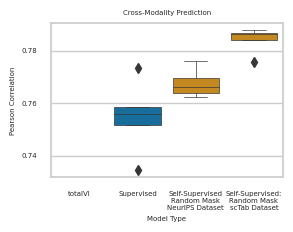

In [19]:
# Rename models
def rename_model(model_name):
    if "No_SSL" in model_name:
        return "Supervised"
    elif "SSL_Random_Mask" in model_name and "20M" in model_name:
        return "Self-Supervised:\nRandom Mask\nscTab Dataset"
    elif "SSL_Random_Mask" in model_name and "NeurIPS" in model_name:
        return "Self-Supervised\nRandom Mask\nNeurIPS Dataset"
    elif "totalVI" in model_name:
        return "totalVI"
    else:
        return model_name

mean_results_df['Model Type'] = mean_results_df['Model'].apply(rename_model)

# Define the order of models
model_order = ["totalVI", "Supervised", "Self-Supervised\nRandom Mask\nNeurIPS Dataset", "Self-Supervised:\nRandom Mask\nscTab Dataset"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised:\nRandom Mask\nscTab Dataset": color_ssl,
    "Self-Supervised\nRandom Mask\nNeurIPS Dataset": color_ssl,
    "totalVI": palette_colors[3]
}

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels

# Box plot for Pearson Correlation
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Model Type', y='Pearson Correlation', data=mean_results_df, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xlabel('Model Type', fontdict=font)
ax1.set_ylabel('Pearson Correlation', fontdict=font)
ax1.set_title('Cross-Modality Prediction', fontdict=font)

# Set font for all tick labels to match the fontdict
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)
# plt.savefig(RESULT_PATH + "/multiomics/pearson_corr.svg", bbox_inches='tight')  # Save as SVG

plt.show()

# Figure 2 - Plot Correlations

In [17]:
adata_test = adata[adata.obs['split'] == 'test']
adata_test

View of AnnData object with n_obs × n_vars = 8154 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [18]:
model_dirs = [
    MODEL_PATH + "/final_models/multiomics/New_No_SSL_run0/default/version_5/checkpoints/best_checkpoint_val.ckpt",
    MODEL_PATH + "/final_models/multiomics/SSL_Random_Mask_20Mrun8/default/version_0/checkpoints/best_checkpoint_val.ckpt",
]

In [19]:
all_protein_predictions, all_embs = get_pred_dir(model_dirs=model_dirs, adata=adata_test, test_dl=test_dl)

Getting predictions for New_No_SSL_run0...
Getting predictions for SSL_Random_Mask_20Mrun8...


In [20]:
all_embs

{'New_No_SSL_run0': tensor([[ 0.4816,  0.3323, -0.1568,  ..., -0.1467, -0.2975, -0.0437],
         [ 0.4592,  0.3377, -0.1007,  ..., -0.1875, -0.3005, -0.0796],
         [-0.1522,  0.1465,  0.0746,  ...,  0.0304,  0.1418,  0.0810],
         ...,
         [-0.2316,  0.4064, -0.0258,  ...,  0.3267,  0.1807,  0.1486],
         [ 0.0044,  0.0083, -0.1853,  ...,  0.3836,  0.4285, -0.1254],
         [ 0.0289,  0.0357, -0.0902,  ...,  0.3174,  0.4263, -0.0198]]),
 'SSL_Random_Mask_20Mrun8': tensor([[ 0.0272,  0.0400, -0.0127,  ...,  0.0521, -0.0340, -0.0099],
         [ 0.0298,  0.0334, -0.0091,  ...,  0.0595, -0.0335, -0.0039],
         [ 0.0416,  0.0066, -0.0008,  ...,  0.0171, -0.0151, -0.0145],
         ...,
         [ 0.0028,  0.0596, -0.0072,  ...,  0.0581, -0.0265, -0.0129],
         [ 0.0084,  0.0613,  0.0041,  ...,  0.0457, -0.0190, -0.0143],
         [ 0.0004,  0.0588, -0.0134,  ...,  0.0564, -0.0252, -0.0069]])}

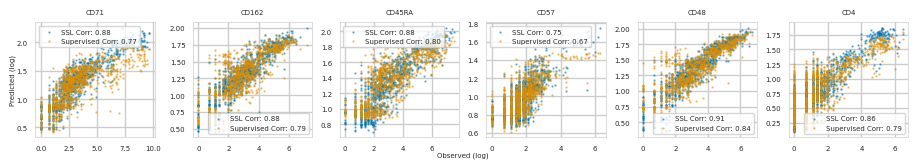

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch

# Set the font dictionary for the plots
font = {'family': 'sans-serif', 'size': 5}
plt.rc('font', **font)

# Assuming 'adata_test' is your AnnData object and 'all_protein_predictions' is your prediction dictionary
# Convert true protein counts from AnnData to DataFrame and take log
protein_names = list(adata_test.obsm['protein_counts'].columns)
true_proteins_df = pd.DataFrame(adata_test.obsm['protein_counts'], columns=protein_names)
true_proteins_log = np.log1p(true_proteins_df)

# Convert predictions to DataFrames and take log, ensuring indices match
predictions_dfs = {}
correlations = []
for model_name, pred_tensor in all_protein_predictions.items():
    pred_df = pd.DataFrame(pred_tensor.numpy()[:, 2000:2134], index=true_proteins_df.index, columns=protein_names)
    predictions_dfs[model_name] = np.log1p(pred_df)  # Assuming predictions need to be log-transformed

for model_name, pred_df in predictions_dfs.items():
    for protein in protein_names:
        corr = pearsonr(true_proteins_log[protein], pred_df[protein])[0]
        correlations.append((protein, model_name, corr))

# Create a DataFrame from the correlations
correlations_df = pd.DataFrame(correlations, columns=['Protein', 'Model', 'Correlation'])

# Pivot the DataFrame to have models as columns
correlations_pivot = correlations_df.pivot(index='Protein', columns='Model', values='Correlation')

# Calculate the absolute difference in correlations between the two models
correlations_pivot['Corr_Diff'] = abs(correlations_pivot['SSL_Random_Mask_20Mrun8'] - correlations_pivot['New_No_SSL_run0'])

# Sort by the difference and select the top 16 proteins
selected_proteins = correlations_pivot.nlargest(6, 'Corr_Diff').index.tolist()

# Initialize the plot with a smaller figure size
fig, axes = plt.subplots(1, 6, figsize=(9, 1.5), constrained_layout=True)
axes = axes.flatten()

for i, protein in enumerate(selected_proteins):
    ax = axes[i]
    
    # Calculate correlations for the legend
    corr_ssl = correlations_pivot.at[protein, 'SSL_Random_Mask_20Mrun8']
    corr_supervised = correlations_pivot.at[protein, 'New_No_SSL_run0']
    
    # Randomly sample 100 points for plotting
    sample_indices = np.random.choice(true_proteins_log.index, size=1000, replace=False)
    sampled_true_proteins = true_proteins_log.loc[sample_indices, protein]
    sampled_predictions_ssl = predictions_dfs['SSL_Random_Mask_20Mrun8'].loc[sample_indices, protein]
    sampled_predictions_supervised = predictions_dfs['New_No_SSL_run0'].loc[sample_indices, protein]
    
    # Scatter plot for SSL model
    ax.scatter(sampled_true_proteins, sampled_predictions_ssl,
               alpha=0.5, s=0.5, label=f'SSL Corr: {corr_ssl:.2f}')  # Add appropriate color if needed
    
    # Scatter plot for Supervised model
    ax.scatter(sampled_true_proteins, sampled_predictions_supervised,
               alpha=0.5, s=0.5, label=f'Supervised Corr: {corr_supervised:.2f}')  # Add appropriate color if needed
    
    # Create the legend with the specified font size
    ax.legend(prop={'size': font['size']})

    # Set the linewidth of the plot box and adjust tick length
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', labelsize=font['size'], width=0.5, length=2)

    # Set the title with the specified font size
    ax.set_title(f'{protein}', fontsize=font['size'])

# Set common labels with adjusted coordinates and padding
fig.text(0.5, 0.001, 'Observed (log)', ha='center', va='center', fontsize=font['size'])
fig.text(0.001, 0.5, 'Predicted (log)', ha='center', va='center', rotation='vertical', fontsize=font['size'])

# Assuming RESULT_PATH is defined
plt.savefig(RESULT_PATH + "/multiomics/Corr_Plots.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Figure 3 - Protein Counts on UMAPs

In [60]:
selected_protein='CD71'  # Random protein for plotting

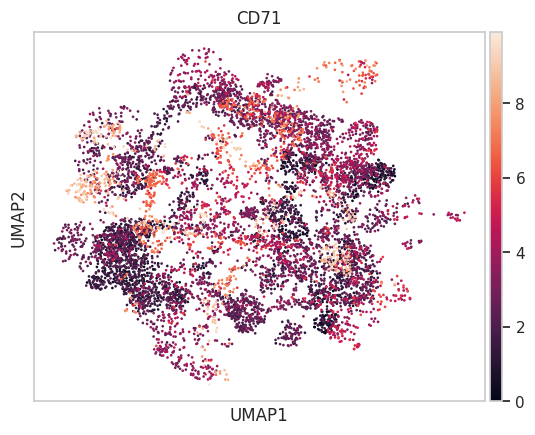

In [61]:
adata_test.obs[selected_protein] = np.log1p(adata_test.obsm['protein_counts'][selected_protein].values)
adata_test.obsm['X_umap'] = adata_test.obsm['GEX_X_umap']
sc.pl.umap(adata_test, color = selected_protein)

In [62]:
num_genes = 2000
num_proteins = 134
protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
protein_preds = all_protein_predictions['New_No_SSL_run0'][:, num_genes:num_genes+num_proteins][:, protein_idx]
supervised_embs.obs[selected_protein] = protein_preds
protein_preds.shape

torch.Size([8154])

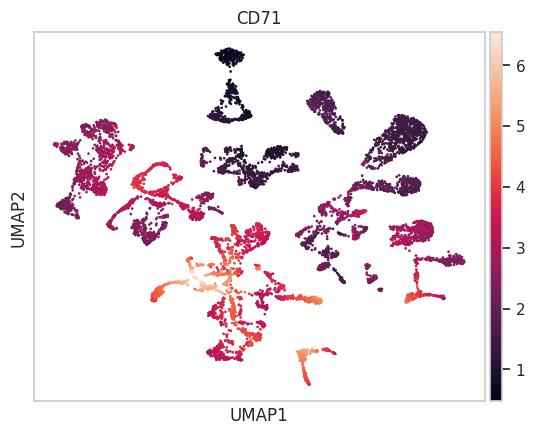

In [63]:
sc.pl.umap(supervised_embs, color = selected_protein)

In [64]:
num_genes = 2000
num_proteins = 134
protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
protein_preds = all_protein_predictions['SSL_Random_Mask_20Mrun8'][:, num_genes:num_genes+num_proteins][:, protein_idx]
self_supervised_embs.obs[selected_protein] = protein_preds
protein_preds.shape

torch.Size([8154])

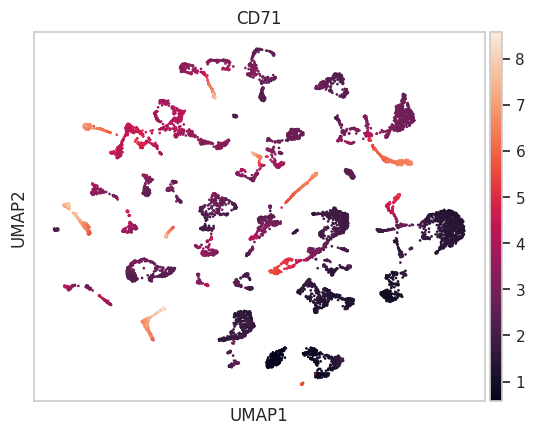

In [65]:
sc.pl.umap(self_supervised_embs, color = selected_protein)

In [66]:
umap_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust the size as needed


In [67]:
# Prepare AnnData objects
supervised_embs = anndata.AnnData(X=all_embs['New_No_SSL_run0'].numpy(), obs=adata_test.obs)
self_supervised_embs = anndata.AnnData(X=all_embs['SSL_Random_Mask_20Mrun8'].numpy(), obs=adata_test.obs)

# Compute UMAPs
sc.pp.neighbors(supervised_embs, use_rep='X')
sc.pp.neighbors(self_supervised_embs, use_rep='X')
sc.tl.umap(supervised_embs)
sc.tl.umap(self_supervised_embs)

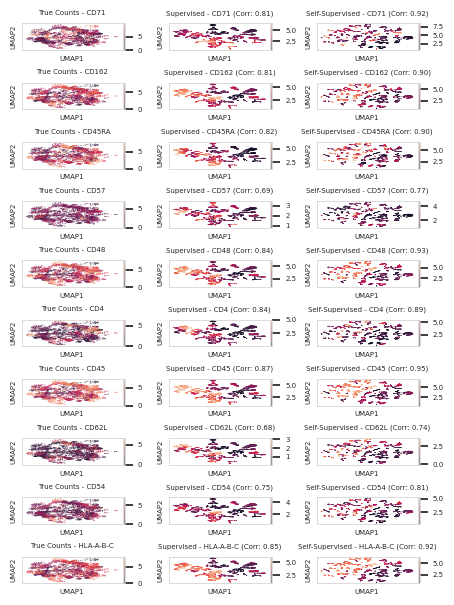

In [68]:
figsize=(4.5, 6)

# Determine the number of rows for subplots
n_rows = len(selected_proteins)

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, 3, figsize=figsize)

for i, selected_protein in enumerate(selected_proteins):
    # True protein counts
    adata_test.obs[selected_protein] = np.log1p(adata_test.obsm['protein_counts'][selected_protein].values)
    adata_test.obsm['X_umap'] = adata_test.obsm['GEX_X_umap']

    sc.pl.umap(adata_test, color=selected_protein, ax=axs[i, 0], show=False, title=f"True Counts - {selected_protein}", size=0.5)

    # Supervised predictions
    protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
    protein_preds = all_protein_predictions['New_No_SSL_run0'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    supervised_embs.obs[selected_protein] = protein_preds

    pearson_corr_supervised = pearsonr(adata_test.obs[selected_protein], protein_preds)[0]
    sc.pl.umap(supervised_embs, color=selected_protein, ax=axs[i, 1], show=False, title=f"Supervised - {selected_protein} (Corr: {pearson_corr_supervised:.2f})", size=0.5)

    # Self-supervised predictions
    protein_preds = all_protein_predictions['SSL_Random_Mask_20Mrun8'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    self_supervised_embs.obs[selected_protein] = protein_preds

    pearson_corr_self_supervised = pearsonr(adata_test.obs[selected_protein], protein_preds)[0]
    sc.pl.umap(self_supervised_embs, color=selected_protein, ax=axs[i, 2], show=False, title=f"Self-Supervised - {selected_protein} (Corr: {pearson_corr_self_supervised:.2f})", size=0.5)


for ax in axs.flat:
    # Adjust font of plot title and labels
    ax.title.set_fontsize(fontdict['fontsize'])
    ax.xaxis.label.set_fontsize(fontdict['fontsize'])
    ax.yaxis.label.set_fontsize(fontdict['fontsize'])
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(fontdict['fontsize'])
        label.set_family(fontdict['family'])

    # Adjust spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Get the colorbar from the Heatmap
    cbar = ax.collections[0].colorbar

    # Ensure the colorbar ticks are visible
    cbar.ax.tick_params(labelsize=fontdict['fontsize'])

    # Change the colorbar axis font size and thickness
    cbar.ax.yaxis.label.set_fontsize(fontdict['fontsize'])
    cbar.outline.set_linewidth(0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(RESULT_PATH + "/multiomics/UMAPs.svg", bbox_inches='tight')  # Save as SVG
plt.show()

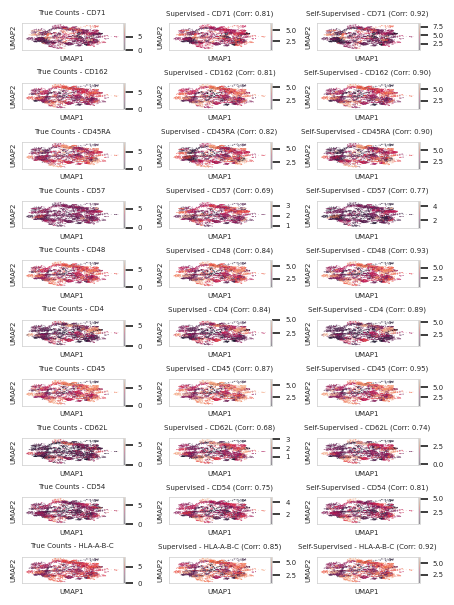

In [70]:
figsize=(4.5, 6)

# Create a DataFrame from the correlations
correlations_df = pd.DataFrame(correlations, columns=['Protein', 'Model', 'Correlation'])

# Pivot the DataFrame to have models as columns
correlations_pivot = correlations_df.pivot(index='Protein', columns='Model', values='Correlation')

# Calculate the absolute difference in correlations between the two models
correlations_pivot['Corr_Diff'] = abs(correlations_pivot['SSL_Random_Mask_20Mrun8'] - correlations_pivot['New_No_SSL_run0'])

# Sort by the difference and select the top 16 proteins
selected_proteins = correlations_pivot.nlargest(10, 'Corr_Diff').index.tolist()

# Determine the number of rows for subplots
n_rows = len(selected_proteins)

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, 3, figsize=figsize)

# Prepare AnnData objects
supervised_embs = anndata.AnnData(X=all_embs['New_No_SSL_run0'].numpy(), obs=adata_test.obs)
self_supervised_embs = anndata.AnnData(X=all_embs['SSL_Random_Mask_20Mrun8'].numpy(), obs=adata_test.obs)

# Compute UMAPs
sc.pp.neighbors(supervised_embs, use_rep='X')
sc.pp.neighbors(self_supervised_embs, use_rep='X')
sc.tl.umap(supervised_embs)
sc.tl.umap(self_supervised_embs)

for i, selected_protein in enumerate(selected_proteins):
    # True protein counts
    adata_test.obs[selected_protein] = np.log1p(adata_test.obsm['protein_counts'][selected_protein].values)
    adata_test.obsm['X_umap'] = adata_test.obsm['GEX_X_umap']

    sc.pl.umap(adata_test, color=selected_protein, ax=axs[i, 0], show=False, title=f"True Counts - {selected_protein}", size=0.5)

    # Supervised predictions
    protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
    protein_preds = all_protein_predictions['New_No_SSL_run0'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    adata_test.obs['supervised_' + selected_protein] = protein_preds

    pearson_corr_supervised = pearsonr(adata_test.obs[selected_protein], protein_preds)[0]
    sc.pl.umap(adata_test, color='supervised_' + selected_protein, ax=axs[i, 1], show=False, title=f"Supervised - {selected_protein} (Corr: {pearson_corr_supervised:.2f})", size=0.5)

    # Self-supervised predictions
    protein_preds = all_protein_predictions['SSL_Random_Mask_20Mrun8'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    adata_test.obs['ssl_' + selected_protein] = protein_preds

    pearson_corr_self_supervised = pearsonr(adata_test.obs[selected_protein], protein_preds)[0]
    sc.pl.umap(adata_test, color='ssl_' + selected_protein, ax=axs[i, 2], show=False, title=f"Self-Supervised - {selected_protein} (Corr: {pearson_corr_self_supervised:.2f})", size=0.5)


for ax in axs.flat:
    # Adjust font of plot title and labels
    ax.title.set_fontsize(fontdict['fontsize'])
    ax.xaxis.label.set_fontsize(fontdict['fontsize'])
    ax.yaxis.label.set_fontsize(fontdict['fontsize'])
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(fontdict['fontsize'])
        label.set_family(fontdict['family'])

    # Adjust spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Get the colorbar from the Heatmap
    cbar = ax.collections[0].colorbar

    # Ensure the colorbar ticks are visible
    cbar.ax.tick_params(labelsize=fontdict['fontsize'])

    # Change the colorbar axis font size and thickness
    cbar.ax.yaxis.label.set_fontsize(fontdict['fontsize'])
    cbar.outline.set_linewidth(0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(RESULT_PATH + "/multiomics/UMAPs_same_adata.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Merged Figure

In [77]:
# 1) Compute selected proteins

# Convert true protein counts from AnnData to DataFrame and take log
protein_names = list(adata_test.obsm['protein_counts'].columns)
true_proteins_df = pd.DataFrame(adata_test.obsm['protein_counts'], columns=protein_names)
true_proteins_log = np.log1p(true_proteins_df)

# Convert predictions to DataFrames and take log, ensuring indices match
predictions_dfs = {}
correlations = []
for model_name, pred_tensor in all_protein_predictions.items():
    pred_df = pd.DataFrame(pred_tensor.numpy()[:, 2000:2134], index=true_proteins_df.index, columns=protein_names)
    predictions_dfs[model_name] = np.log1p(pred_df)  # Assuming predictions need to be log-transformed

for model_name, pred_df in predictions_dfs.items():
    for protein in protein_names:
        corr = pearsonr(true_proteins_log[protein], pred_df[protein])[0]
        correlations.append((protein, model_name, corr))

# Create a DataFrame from the correlations
correlations_df = pd.DataFrame(correlations, columns=['Protein', 'Model', 'Correlation'])

# Pivot the DataFrame to have models as columns
correlations_pivot = correlations_df.pivot(index='Protein', columns='Model', values='Correlation')

# Calculate the absolute difference in correlations between the two models
correlations_pivot['Corr_Diff'] = abs(correlations_pivot['SSL_Random_Mask_20Mrun8'] - correlations_pivot['New_No_SSL_run0'])

# Sort by the difference and select the top 16 proteins
selected_proteins = correlations_pivot.nlargest(10, 'Corr_Diff').index.tolist()



# 2) Prepare adatas
# Prepare AnnData objects
supervised_embs = anndata.AnnData(X=all_embs['New_No_SSL_run0'].numpy(), obs=adata_test.obs)
self_supervised_embs = anndata.AnnData(X=all_embs['SSL_Random_Mask_20Mrun8'].numpy(), obs=adata_test.obs)


# Compute UMAPs
sc.pp.neighbors(supervised_embs, use_rep='X')
sc.pp.neighbors(self_supervised_embs, use_rep='X')
sc.pp.neighbors(adata_test, use_rep='X')
sc.tl.umap(supervised_embs)
sc.tl.umap(self_supervised_embs)
sc.tl.umap(adata_test)

num_genes = 2000
num_proteins = 134
for selected_protein in selected_proteins:
    protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
    protein_preds = all_protein_predictions['New_No_SSL_run0'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    supervised_embs.obs[selected_protein] = protein_preds
    supervised_embs.obs['true_' + selected_protein] = np.log1p(adata_test.obsm['protein_counts'][selected_protein].values)

num_genes = 2000
num_proteins = 134
for selected_protein in selected_proteins:
    protein_idx = adata_test.obsm['protein_counts'].columns.get_loc(selected_protein)
    protein_preds = all_protein_predictions['SSL_Random_Mask_20Mrun8'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    self_supervised_embs.obs[selected_protein] = protein_preds
    self_supervised_embs.obs['true_' + selected_protein] = np.log1p(adata_test.obsm['protein_counts'][selected_protein].values)

In [78]:
# randomly subset adata for plotting

num_samples = supervised_embs.X.shape[0]
selected_indices = np.random.choice(num_samples, size=1000, replace=False)
plt_supervised_embs = supervised_embs[selected_indices]
plt_self_supervised_embs = self_supervised_embs[selected_indices]

In [80]:
1+1

2

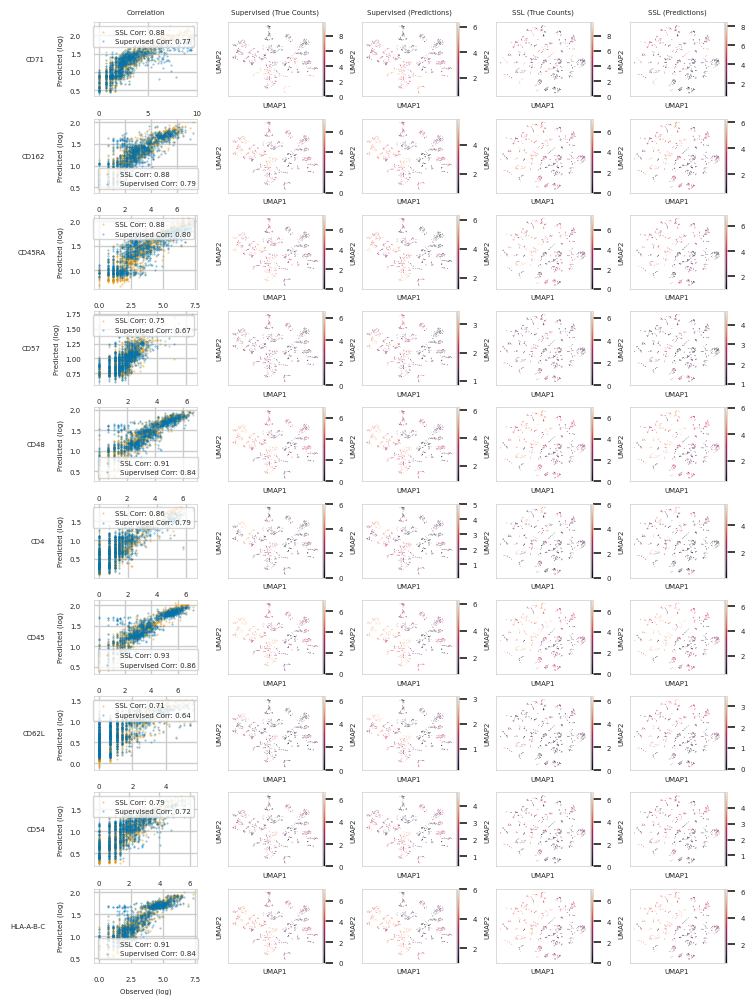

In [83]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

# Assuming the font, tick_font, and color variables are already defined in your notebook

# Determine the number of rows and columns for subplots
n_rows = len(selected_proteins)
n_cols = 5
figsize = (15 / 2, n_rows )  # Adjust as needed

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)


for i, protein in enumerate(selected_proteins):
    # Add row title (protein name) to the first column
    axs[i, 0].annotate(protein, xy=(0, 0.5), xytext=(-axs[i, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[i, 0].yaxis.label, textcoords='offset points',
                    size=fontdict['fontsize'], ha='right', va='center')
    
    # Column 1: Correlation Plot
    ax = axs[i, 0]
    sample_indices = np.random.choice(true_proteins_log.index, size=1000, replace=False)
    sampled_true_proteins = true_proteins_log.loc[sample_indices, protein]
    sampled_predictions_ssl = predictions_dfs['SSL_Random_Mask_20Mrun8'].loc[sample_indices, protein]
    sampled_predictions_supervised = predictions_dfs['New_No_SSL_run0'].loc[sample_indices, protein]
    
    # Calculate correlations for the legend
    corr_ssl = correlations_pivot.at[protein, 'SSL_Random_Mask_20Mrun8']
    corr_supervised = correlations_pivot.at[protein, 'New_No_SSL_run0']
    
    # Scatter plots with color
    ax.scatter(sampled_true_proteins, sampled_predictions_ssl, alpha=0.5, s=0.2, label=f'SSL Corr: {corr_ssl:.2f}', color=color_ssl)
    ax.scatter(sampled_true_proteins, sampled_predictions_supervised, alpha=0.5, s=0.2, label=f'Supervised Corr: {corr_supervised:.2f}', color=color_supervised)
    ax.legend(prop=font)
    ax.set_title('')

    # Apply font settings to axis labels and ticks
    ax.set_xlabel('Observed (log)', fontdict=font)
    ax.set_ylabel('Predicted (log)', fontdict=font)
    ax.tick_params(axis='both', labelsize=tick_font['fontsize'])

    # Column 2: UMAPs - Supervised + True Counts   
    ax = axs[i, 1]
    sc.pl.umap(plt_supervised_embs, color='true_' + protein, ax=ax, show=False, size=0.5)
    ax.set_title('')
    ax.set_xlabel('UMAP1', fontdict=font)
    ax.set_ylabel('UMAP2', fontdict=font)
    ax.tick_params(axis='both', labelsize=tick_font['fontsize'])
    

    # Column 3: UMAPs - Supervised + Supervised Preds Counts
    protein_preds = all_protein_predictions['New_No_SSL_run0'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    pearson_corr_supervised = pearsonr(adata_test.obs[protein], protein_preds)[0]
    ax = axs[i, 2]
    sc.pl.umap(plt_supervised_embs, color=protein, ax=ax, show=False, size=0.5)
    ax.set_title('')
    ax.set_xlabel('UMAP1', fontdict=font)
    ax.set_ylabel('UMAP2', fontdict=font)
    ax.tick_params(axis='both', labelsize=tick_font['fontsize'])

    # Column 4: UMAPs - SSL True Counts
    ax = axs[i, 3]
    sc.pl.umap(plt_self_supervised_embs, color='true_' + protein, ax=ax, show=False, size=0.5)
    ax.set_title('')
    ax.set_xlabel('UMAP1', fontdict=font)
    ax.set_ylabel('UMAP2', fontdict=font)
    ax.tick_params(axis='both', labelsize=tick_font['fontsize'])

    # Column 5: UMAPs - SSL Predictions
    protein_preds = all_protein_predictions['SSL_Random_Mask_20Mrun8'][:, num_genes:num_genes+num_proteins][:, protein_idx]
    pearson_corr_self_supervised = pearsonr(adata_test.obs[selected_protein], protein_preds)[0]
    ax = axs[i, 4]
    sc.pl.umap(plt_self_supervised_embs, color=protein, ax=ax, show=False, size=0.5)
    ax.set_title('')
    ax.set_xlabel('UMAP1', fontdict=font)
    ax.set_ylabel('UMAP2', fontdict=font)
    ax.tick_params(axis='both', labelsize=tick_font['fontsize'])

    
for ax in axs.flat:
    # [Adjust font of plot title and labels]

    # Adjust spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Adjusting font styles for colorbar
    if ax.collections:
        cbar = ax.collections[0].colorbar
        if cbar:
            cbar.ax.tick_params(labelsize=fontdict['fontsize'])
            cbar.ax.yaxis.label.set_fontsize(fontdict['fontsize'])
            cbar.outline.set_linewidth(0.5)
            
            
# Add column titles
column_titles = ['Correlation', 'Supervised (True Counts)', 'Supervised (Predictions)', 'SSL (True Counts)', 'SSL (Predictions)']
for col, col_title in enumerate(column_titles):
    axs[0, col].set_title(col_title, fontdict=font)
            
# Adjust layout and save the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust hspace and wspace as needed
plt.savefig(RESULT_PATH + "/multiomics/Combined_Plots.svg", bbox_inches='tight')
plt.show()
